# Lab : Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

We begin with the standard imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Non-negative Matrix Factorization is a model where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.

Fill in the following class that implements a NMF by multiplicative updates using the Frobenius norm or the Kullback-Leiber divergence as loss function (implement both). Try 10 different random initializations and choose the best one.

In [2]:
class my_NMF():
    
    def __init__(self, n_components, loss, epsilon, mu = 0, nu = 0, lambda_ = 0, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_: float
            convergence
        loss_ = {"Frobenius", "KL"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        mu_ : float
            Regularized Frobenius
        '''
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.W_ = None
        self.H_ = None
        self.norm_ = None
        self.mu_= mu
        self.nu_ = nu
        self.lambda_ = lambda_
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """     

        n,p=X.shape
        rng=np.random.RandomState(42)
        self.W_=rng.uniform(0,1,(n,self.n_components_))
        self.H_=rng.uniform(0,1,(self.n_components_,p))        
        
        convergence=False
        it=0
        tic=time.time()
        
        while not(convergence) and it<self.max_iter_:
            if self.loss_=="Frobenius":
                self.W_ = self.W_ * ((np.dot(X,self.H_.T))/np.dot(np.dot(self.W_,self.H_),self.H_.T))

                self.H_ = self.H_ * ((np.dot(self.W_.T,X))/np.dot(np.dot(self.W_.T,self.W_),self.H_))

                self.norm_=np.linalg.norm(X-np.dot(self.W_,self.H_))
            
            elif self.loss_=="KL":
                from scipy.stats import entropy as normKL
                
                self.W_ = self.W_ * np.einsum('kl,il->ik', self.H_, X/np.dot(self.W_,self.H_)) / np.einsum('kl->k',self.H_)
                
                self.H_ = self.H_ * np.einsum('ik,ij->kj', self.W_, X/np.dot(self.W_,self.H_)) / np.einsum('ik->k',self.W_).reshape(-1,1)

                self.norm_=np.sum(np.dot(self.W_,self.H_)-X) + normKL(X.flatten(),np.dot(self.W_,self.H_).flatten())

            if self.norm_<=self.epsilon_:
                convergence=True
            it+=1
            
        toc=time.time()
        self.it_ = it
        print("Fitted with {} iterations in {} s".format(self.it_,np.round(toc-tic,2)))

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

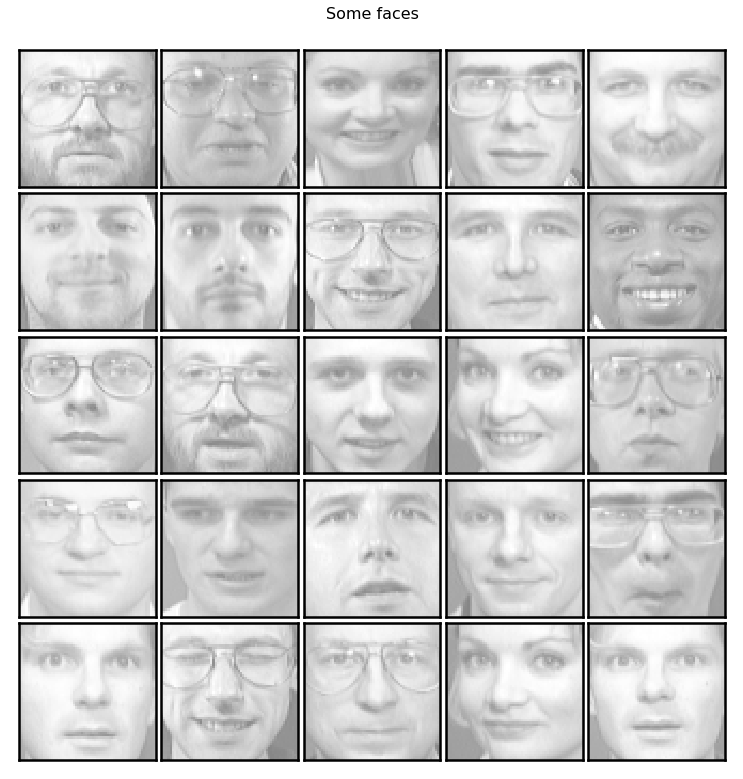

In [3]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
def plot_face_weights(im_number, grid, image_shape):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    plt.setp((ax1, ax2, ax3), xticks=[], yticks=[])
    
    ax1.imshow(faces[im_number].reshape(image_shape), cmap=plt.cm.gray)
    ax1.set_title("True Face", fontsize="12")
    
    ax2.imshow(NMF_faces.W_.dot(NMF_faces.H_).T[im_number].reshape(image_shape), cmap=plt.cm.gray)
    ax2.set_title("Approximated Face", fontsize="12")
    
    ax3.imshow(NMF_faces.H_[:,im_number].reshape(grid,grid), cmap=plt.cm.gray)
    ax3.set_title("Face weights for each facial features above", fontsize="12")    

    plt.tight_layout()
    plt.show()
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

Apply your NMF algorithm for this dataset and plot the approximated face pictures.

In [4]:
# TODO
n_components=36
NMF_faces=my_NMF(loss='KL',epsilon=1e-2,n_components=n_components,max_iter=300)
NMF_faces.fit_transform(faces.T)

Fitted with 159 iterations in 17.44 s


- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Choose one face, plot its corresponding weights (in $H$) in a grid  and explain the interpretation of the both factor matrices.

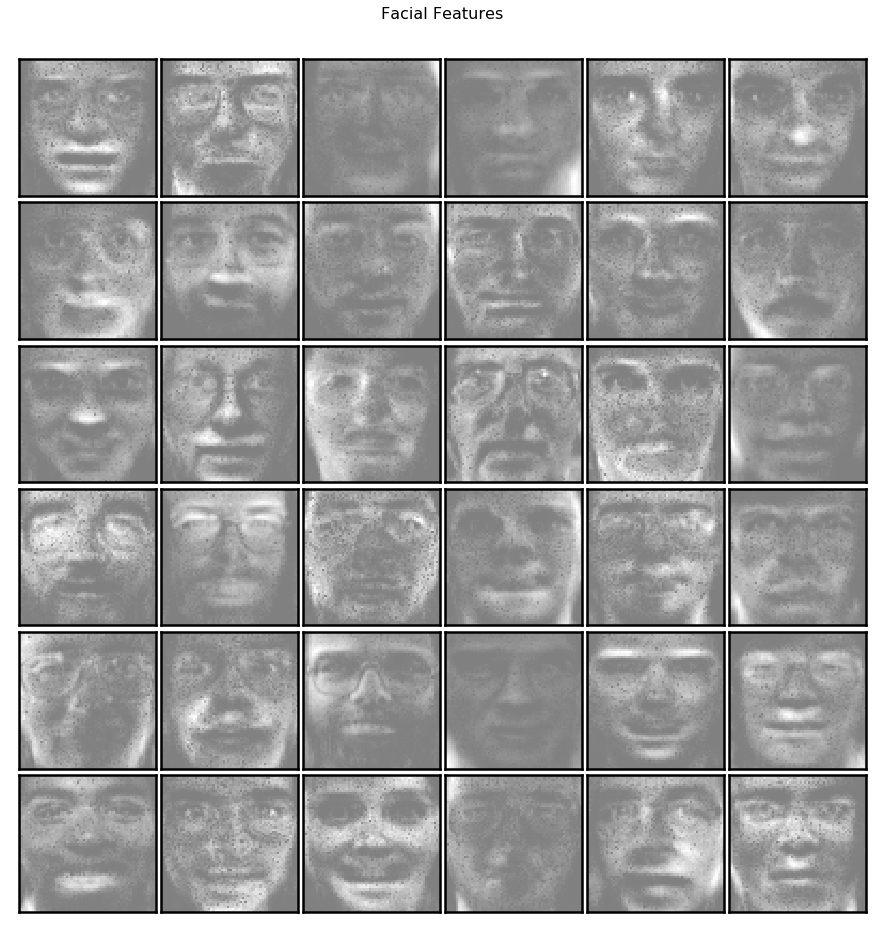

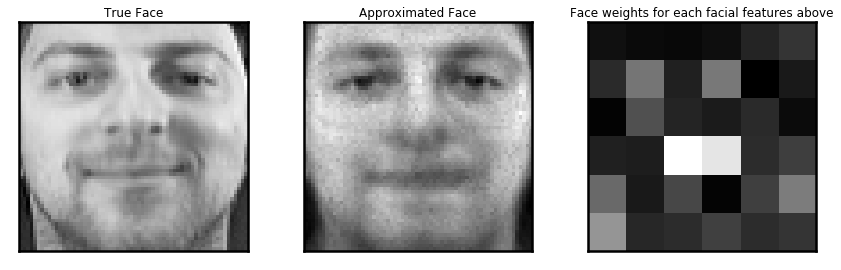

In [5]:
# TODO
grid=int(np.sqrt(n_components))
plot_faces("Facial Features", NMF_faces.W_.T, image_shape, n_col=grid, n_row=grid)

face_number=13
plot_face_weights(face_number, grid, image_shape)

Each "pixel" in the weights matrix (plotted at bottom right), represents the importance of each facial feature ploted above for the chosen face. The darker the pixel, the more important is the corresponding facial feature.

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with NMF. Print the most common words of each topic.

In [6]:
# TODO
from sklearn.datasets import fetch_20newsgroups_vectorized, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the documents text
docs_text=fetch_20newsgroups().data

# Vectorizing the documents with TF IDF
vectorizer=TfidfVectorizer(stop_words="english",min_df=0.003)
docs_vectorized=vectorizer.fit_transform(docs_text)
vocab=np.array(vectorizer.get_feature_names())
print(docs_vectorized.shape)

(11314, 5780)


In [7]:
# TODO
n_topics=5
NMF_docs=my_NMF(loss='Frobenius',epsilon=1e-2,n_components=n_topics,max_iter=50)
NMF_docs.fit_transform(docs_vectorized.toarray().T)

Fitted with 50 iterations in 82.16 s


In [8]:
# Most common words of each topic
topics=vocab[np.argsort(NMF_docs.W_.T,axis=1)[:,::-1].flatten()].reshape(NMF_docs.W_.T.shape).T[:10,:]
pd.DataFrame(topics, columns=["Topic {}".format(i+1) for i in range(n_topics)])

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,windows,god,edu,people,com
1,use,jesus,university,israel,netcom
2,uk,bible,cs,government,hp
3,drive,people,host,gun,article
4,key,christian,nntp,israeli,writes
5,card,christians,posting,don,ibm
6,ac,believe,organization,think,sun
7,dos,faith,subject,armenian,organization
8,file,christ,lines,turkish,subject
9,using,say,article,right,lines
